**BY**

**Prankur Garg**
**(pgarg03)**

**Hitesh Thadani**
**(hthadhan)**

# **ANN PROJECT**


In this notebook, we have tried to perform prediction of traffic volume on a given dataset using various models and comparing their performance and results at the end to find out which one is better. The dataset used in this notebook is already pre-processed and is ready to be used. 

In [ ]:
import math
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import matplotlib.pyplot as plt

In [ ]:
dataset  = pd.read_csv("full_data_holi_nonholi.csv", encoding= 'unicode_escape')

In [ ]:
dataset.head()

,date_time_new,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day_Week,Weekend,weather_desc,snow_bin,holi,weather_bin,date_time_new.1
0,2013-01-01 00:00:00,1,-9.66,0.0,0.0,58.0,1439.0,1,0,1,0,1,1,2013-01-01 00:00:00
1,2013-01-01 01:00:00,1,-9.37,0.0,0.0,40.0,1502.0,1,0,1,0,1,1,2013-01-01 01:00:00
2,2013-01-01 02:00:00,1,-8.99,0.0,0.0,75.0,933.0,1,0,7,0,1,0,2013-01-01 02:00:00
3,2013-01-01 03:00:00,1,-9.20,0.0,0.0,90.0,576.0,1,0,1,0,1,1,2013-01-01 03:00:00
4,2013-01-01 04:00:00,1,-9.50,0.0,0.0,90.0,372.0,1,0,1,0,1,1,2013-01-01 04:00:00


# **Experiment 1**

For this experiment, we are going to use whole dataset

In [ ]:
dataset['date_time_new'] = pd.to_datetime(dataset['date_time_new'])
dataset = dataset.set_index('date_time_new')

In [ ]:
dataset = dataset.drop(columns=['date_time_new.1', 'holi', 'weather_bin', 'snow_bin'])
dataset = dataset.reindex(columns=['traffic_volume', 'temp','rain_1h', 'snow_1h', 'clouds_all', 'weather_desc','holiday', 'Day_Week', 'Weekend'])

In [ ]:
dataset.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_desc,holiday,Day_Week,Weekend
date_time_new,,,,,,,,,
2013-01-01 00:00:00,1439.0,-9.66,0.0,0.0,58.0,1,1,1,0
2013-01-01 01:00:00,1502.0,-9.37,0.0,0.0,40.0,1,1,1,0
2013-01-01 02:00:00,933.0,-8.99,0.0,0.0,75.0,7,1,1,0
2013-01-01 03:00:00,576.0,-9.20,0.0,0.0,90.0,1,1,1,0
2013-01-01 04:00:00,372.0,-9.50,0.0,0.0,90.0,1,1,1,0


In [ ]:
import tensorflow as tf
tf.random.set_seed(2)

## **Data Prepration**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# ensure all data is float
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
1,0.197665,0.301440,0.0,0.0,0.58,0.125,1.0,0.166667,0.0,0.206319
2,0.206319,0.305789,0.0,0.0,0.40,0.125,1.0,0.166667,0.0,0.128159
3,0.128159,0.311488,0.0,0.0,0.75,0.875,1.0,0.166667,0.0,0.079121
4,0.079121,0.308338,0.0,0.0,0.90,0.125,1.0,0.166667,0.0,0.051099
5,0.051099,0.303839,0.0,0.0,0.90,0.125,1.0,0.166667,0.0,0.057555


Below is the code for when I tried to predict the traffic volume based on 1 year. I took the total number of hours in a year to predict the upcoming years.

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 9) (8760,) (28510, 1, 9) (28510,)


Below is the code for when I tried to predict the traffic volume using the train data for model building and tested on a small portion. I also tried to predict the result based on the validation data. 

In [ ]:
# split into train, test and validate sets
values_ttv = reframed.values
train_ttv, val_ttv, test_ttv = values_ttv[:26089,:], values_ttv[26090:33552,:], values_ttv[33553:,:]

# split into input and outputs
X_train_ttv, y_train_ttv = train_ttv[:, :-1], train_ttv[:, -1]
X_val_ttv, y_val_ttv = val_ttv[:, :-1], val_ttv[:, -1]
X_test_ttv, y_test_ttv = test_ttv[:, :-1], test_ttv[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train_ttv = X_train_ttv.reshape((X_train_ttv.shape[0], 1, X_train_ttv.shape[1]))
X_val_ttv = X_val_ttv.reshape((X_val_ttv.shape[0], 1, X_val_ttv.shape[1]))
X_test_ttv = X_test_ttv.reshape((X_test_ttv.shape[0], 1, X_test_ttv.shape[1]))
print(X_train_ttv.shape, X_val_ttv.shape, X_test_ttv.shape)

(26089, 1, 9) (7462, 1, 9) (3717, 1, 9)


In [ ]:
# specify the number of lag hours
n_hours = 12
n_features = 9

# split into train, test and validate sets
n_obs = n_hours * n_features
reframed_lag = series_to_supervised(scaled, n_hours, 1)
values_lag = reframed_lag.values
train_lag, val_lag, test_lag = values_lag[:26089,:], values_lag[26090:33552,:], values_lag[33553:,:]

# split into input and outputs
X_train_lag, y_train_lag = train_lag[:, :n_obs], train_lag[:, -n_features]
X_val_lag, y_val_lag = val_lag[:, :n_obs], val_lag[:, -n_features]
X_test_lag, y_test_lag = test_lag[:, :n_obs], test_lag[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
X_train_lag = X_train_lag.reshape((X_train_lag.shape[0], n_hours, n_features))
X_val_lag = X_val_lag.reshape((X_val_lag.shape[0], n_hours, n_features))
X_test_lag = X_test_lag.reshape((X_test_lag.shape[0], n_hours, n_features))
print(X_train_lag.shape, X_val_lag.shape, X_test_lag.shape)

(26089, 12, 9) (7462, 12, 9) (3706, 12, 9)


## **LSTM Model**

#### LSTM model where data is predicted using the past 1 year

In [ ]:
# design network for 1 year

pred_time_lstm=[]

start = time.clock()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_lstm.append(end-start)

# fit network
model_lstm_fit = model_lstm.fit(train_X, train_y, epochs=35, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

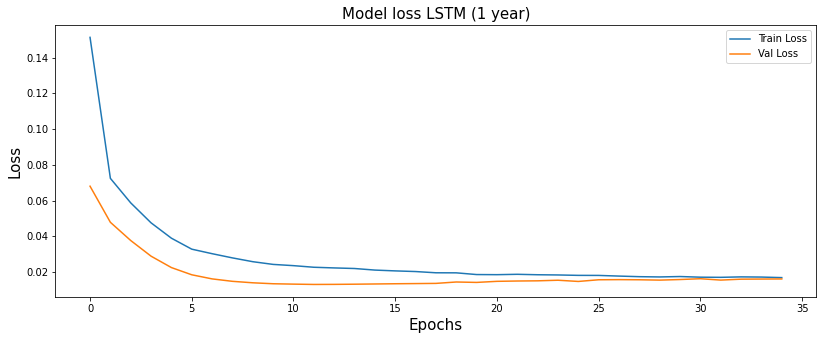

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lstm_fit.history['loss'], label='Train Loss')
plt.plot(model_lstm_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss LSTM (1 year)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction
yhat_lstm = model_lstm.predict(test_X)
test_X_lstm = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat_lstm = concatenate((yhat_lstm, test_X_lstm[:, 1:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]

# invert scaling for actual
test_y_lstm = test_y.reshape((len(test_y), 1))
inv_y_lstm = concatenate((test_y_lstm, test_X_lstm[:, 1:]), axis=1)
inv_y_lstm = scaler.inverse_transform(inv_y_lstm)
inv_y_lstm = inv_y_lstm[:,0]

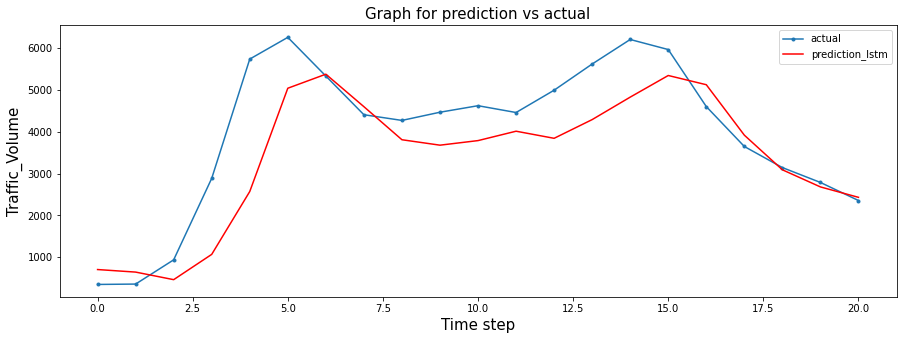

In [ ]:
# Graph for prediction vs actual
aq=[x for x in range(21)]
plt.figure(figsize=(15,5))
plt.plot(aq,inv_y_lstm[:21], marker='.', label="actual")
plt.plot(aq, inv_yhat_lstm[:21], 'r', label="prediction_lstm")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
rmse_lstm_1y = sqrt(mean_squared_error(inv_y_lstm, inv_yhat_lstm))
mse_lstm_1y = mean_squared_error(inv_y_lstm, inv_yhat_lstm)
mae_lstm_1y = mean_absolute_error(inv_y_lstm, inv_yhat_lstm)
pred_time_lstm = math.acos(pred_time_lstm[0])

eval_lstm_1y = {'lstm_1y' : [rmse_lstm_1y, mse_lstm_1y, mae_lstm_1y, pred_time_lstm]}

eval_lstm_1y_df = pd.DataFrame(eval_lstm_1y, columns = ['lstm_1y'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
#pd.options.display.float_format = "{:,.2f}".format
eval_lstm_1y_df

,lstm_1y
Root Mean Square Error,924.100001
Mean Square Error,853960.812500
Mean Absolute Error,695.549622
Processing time in sec,1.205080


For this model, there was a very high mse score as well as the forecast graph was not that accurate which we expected. This is because, we are trying to predict the data based on only previous 1 year which is a very less information.

#### LSTM model using test, train, and validate 

In [ ]:
# design network for train, test and validate
pred_time_lstm_ttv=[]

start = time.clock()
model_lstm_ttv = Sequential()
model_lstm_ttv.add(LSTM(10, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_lstm_ttv.add(Dropout(0.5))
model_lstm_ttv.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lstm_ttv.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_lstm_ttv.append(end-start)

# fit network
model_lstm_ttv_fit = model_lstm_ttv.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

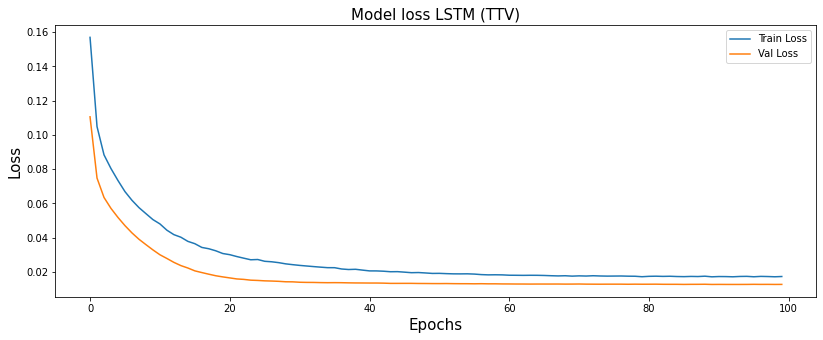

In [ ]:
# evaluate the keras model for TTV
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lstm_ttv_fit.history['loss'], label='Train Loss')
plt.plot(model_lstm_ttv_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss LSTM (TTV)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_ttv = model_lstm_ttv.predict(X_test_ttv)
X_test_rttv = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_ttv = concatenate((ypred_ttv, X_test_rttv[:, 1:]), axis=1)
inv_ypred_ttv = scaler.inverse_transform(inv_ypred_ttv)
inv_ypred_ttv = inv_ypred_ttv[:,0]

# invert scaling for actual
y_test_rttv = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_ttv = concatenate((y_test_rttv, X_test_rttv[:, 1:]), axis=1)
inv_yact_ttv = scaler.inverse_transform(inv_yact_ttv)
inv_yact_ttv = inv_yact_ttv[:,0]

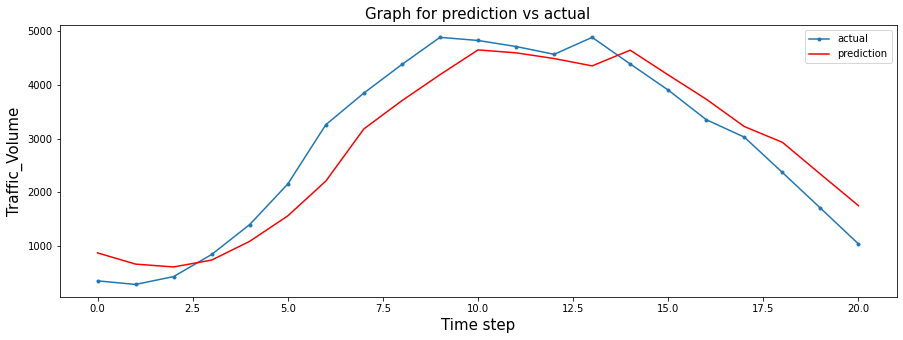

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15,5))
plt.plot(a,inv_yact_ttv[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_ttv[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
rmse_lstm_ttv = sqrt(mean_squared_error(inv_yact_ttv, inv_ypred_ttv))
mse_lstm_ttv = mean_squared_error(inv_yact_ttv, inv_ypred_ttv)
mae_lstm_ttv = mean_absolute_error(inv_yact_ttv, inv_ypred_ttv)
pred_time_lstm_ttv = math.acos(pred_time_lstm_ttv[0])

eval_lstm_ttv = {'lstm_ttv' : [rmse_lstm_ttv, mse_lstm_ttv, mae_lstm_ttv, pred_time_lstm_ttv]}

eval_lstm_ttv_df = pd.DataFrame(eval_lstm_ttv, columns = ['lstm_ttv'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_lstm_ttv_df

,lstm_ttv
Root Mean Square Error,800.357733
Mean Square Error,640572.500000
Mean Absolute Error,604.351624
Processing time in sec,1.165691


This is just a simple LSTM model. For this, I experimented with various parameters like trying different optimizers, number of epochs, batch size, dropout function etc. And the best combination was the one I have mentioned above.

#### LSTM Model with varying hidden layers

In [ ]:
# design network for train, test and validate
pred_time_lstm_hl=[]

start = time.clock()
model_lstm_hl = Sequential()
model_lstm_hl.add(LSTM(10, return_sequences=True, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_lstm_hl.add(Dropout(0.5))
model_lstm_hl.add(LSTM(10))
model_lstm_hl.add(Dropout(0.5))
model_lstm_hl.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lstm_hl.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_lstm_hl.append(end-start)

# fit network
model_lstm_hl_fit = model_lstm_hl.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

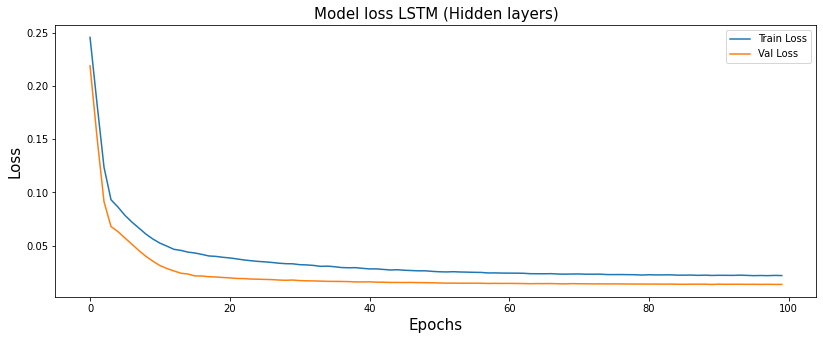

In [ ]:
# evaluate the keras model for varying hidden layers
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lstm_hl_fit.history['loss'], label='Train Loss')
plt.plot(model_lstm_hl_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss LSTM (Hidden layers)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_hl = model_lstm_hl.predict(X_test_ttv)
X_test_hl = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_hl = concatenate((ypred_hl, X_test_hl[:, 1:]), axis=1)
inv_ypred_hl = scaler.inverse_transform(inv_ypred_hl)
inv_ypred_hl = inv_ypred_hl[:,0]

# invert scaling for actual
y_test_hl = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_hl = concatenate((y_test_hl, X_test_hl[:, 1:]), axis=1)
inv_yact_hl = scaler.inverse_transform(inv_yact_hl)
inv_yact_hl = inv_yact_hl[:,0]

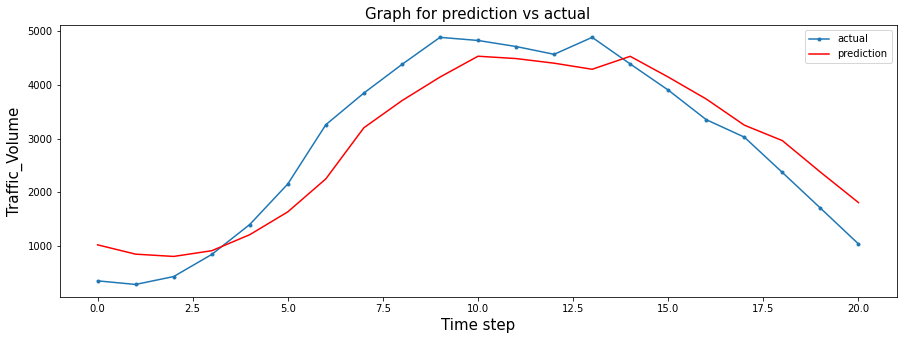

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_hl[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_hl[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
rmse_lstm_hl = sqrt(mean_squared_error(inv_yact_hl, inv_ypred_hl))
mse_lstm_hl = mean_squared_error(inv_yact_hl, inv_ypred_hl)
mae_lstm_hl = mean_absolute_error(inv_yact_hl, inv_ypred_hl)
pred_time_lstm_hl = math.acos(pred_time_lstm_hl[0])

eval_lstm_hl = {'lstm_hl' : [rmse_lstm_hl, mse_lstm_hl, mae_lstm_hl, pred_time_lstm_hl]}

eval_lstm_hl_df = pd.DataFrame(eval_lstm_hl, columns = ['lstm_hl'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_lstm_hl_df

,lstm_hl
Root Mean Square Error,813.685405
Mean Square Error,662083.937500
Mean Absolute Error,630.961792
Processing time in sec,1.020840


I tried various combinations for hidden layers for LSTM. But what I fond is that, with the increase in hidden layers, there is also an increase in MSE score. Also, the graph plot for forcast varies in various cases. For ex. for the model with hidden layer 3, I found that MSE was worse than models for 2 and 1 hidden layers, burt the forcast for 3 hidden layers was better. But as I increased further, the forcast became more distorted. Thus I cose to go with 3 hidden layers.

#### LSTM model using lag timesteps

In [ ]:
# design network for train, test and validate

pred_time_lstm_lag=[]

start = time.clock()
model_lag = Sequential()
model_lag.add(LSTM(10, input_shape=(X_train_lag.shape[1], X_train_lag.shape[2])))
model_lag.add(Dropout(0.5))
model_lag.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_lstm_lag.append(end-start)

# fit network
model_lag_fit = model_lag.fit(X_train_lag, y_train_lag, epochs=100, batch_size=1000, validation_data=(X_val_lag, y_val_lag), verbose=0, shuffle=False)

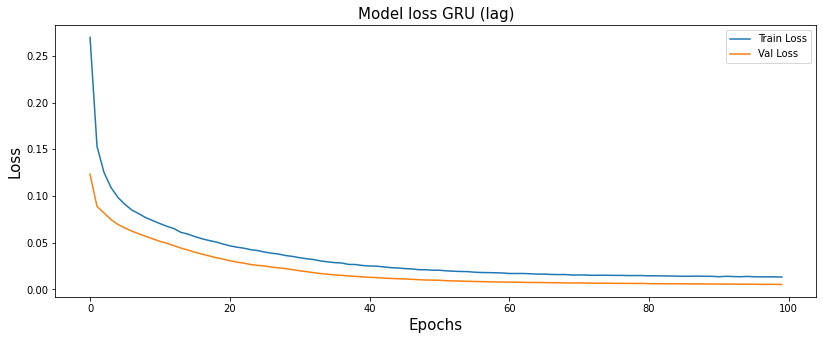

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_fit.history['loss'], label='Train Loss')
plt.plot(model_lag_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag = model_lag.predict(X_test_lag)
X_test_lag_lstm = X_test_lag.reshape((X_test_lag.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag = concatenate((ypred_lag, X_test_lag_lstm[:, -8:]), axis=1)
inv_ypred_lag = scaler.inverse_transform(inv_ypred_lag)
inv_ypred_lag = inv_ypred_lag[:,0]

# invert scaling for actual
y_test_lag_lstm = y_test_lag.reshape((len(y_test_lag), 1))
inv_yact_lag = concatenate((y_test_lag_lstm, X_test_lag_lstm[:, -8:]), axis=1)
inv_yact_lag = scaler.inverse_transform(inv_yact_lag)
inv_yact_lag = inv_yact_lag[:,0]

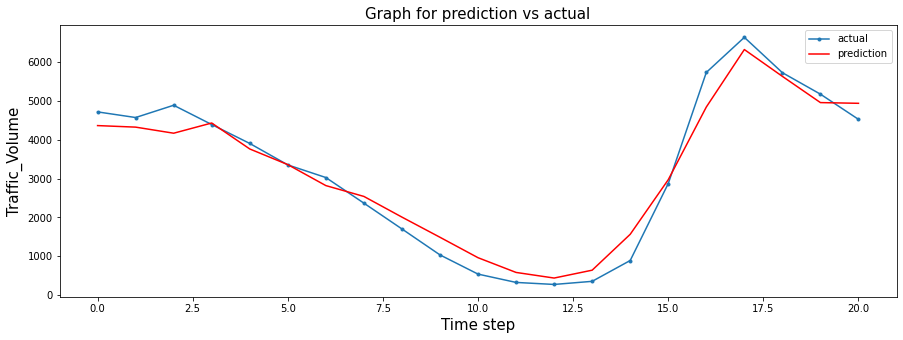

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_lag[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_lag[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_lstm_lag = sqrt(mean_squared_error(inv_yact_lag, inv_ypred_lag))
mse_lstm_lag = mean_squared_error(inv_yact_lag, inv_ypred_lag)
mae_lstm_lag = mean_absolute_error(inv_yact_lag, inv_ypred_lag)
pred_time_lstm_lag = math.acos(pred_time_lstm_lag[0])

eval_lstm_lag = {'lstm_lag' : [rmse_lstm_lag, mse_lstm_lag, mae_lstm_lag, pred_time_lstm_lag]}

eval_lstm_lag_df = pd.DataFrame(eval_lstm_lag, columns = ['lstm_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_lstm_lag_df

,lstm_lag
Root Mean Square Error,476.987307
Mean Square Error,227516.890625
Mean Absolute Error,357.985229
Processing time in sec,1.280958


Apart from lag = 12, I also tried putting different values like 3, 8, 24 etc. In each case, there was a significant difference in the forcasting graph. Out of all these models, model with lag 12 was a bit more on the mark. 

#### Conclusion for LSTM model

In [ ]:
LSTM_eval = {'lstm_1y' : [rmse_lstm_1y, mse_lstm_1y, mae_lstm_1y, pred_time_lstm], 
             'lstm_ttv' : [rmse_lstm_ttv, mse_lstm_ttv, mae_lstm_ttv, pred_time_lstm_ttv],
             'lstm_hl' : [rmse_lstm_hl, mse_lstm_hl, mae_lstm_hl, pred_time_lstm_hl],
             'lstm_lag' : [rmse_lstm_lag, mse_lstm_lag, mae_lstm_lag, pred_time_lstm_lag]       
            }

LSTM_eval_df = pd.DataFrame(LSTM_eval, columns = ['lstm_1y','lstm_ttv','lstm_hl','lstm_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
LSTM_eval_df


,lstm_1y,lstm_ttv,lstm_hl,lstm_lag
Root Mean Square Error,924.100001,800.357733,813.685405,476.987307
Mean Square Error,853960.812500,640572.500000,662083.937500,227516.890625
Mean Absolute Error,695.549622,604.351624,630.961792,357.985229
Processing time in sec,1.205080,1.165691,1.020840,1.280958


According to the above data and looking at the predicted vs actual graph, I can say that among all of the above LSTM models, model using lag = 12 is by far more accurate in forcasting. 

## **GRU Model**

For the sake of fair comparison, we have used same parameters as hvae done for the lstm model. Although we did experimented with the parameters, but we still decided to the same parameters to highlight the difference in performance. 

#### GRU model where data is predicted using the past 1 year

In [ ]:
# design network
pred_time_gru=[]

start = time.clock()
model_gru = Sequential()
model_gru.add(GRU(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_gru.append(end-start)

# fit network
model_gru_fit = model_gru.fit(train_X, train_y, epochs=100, batch_size=1000, validation_data=(test_X, test_y), verbose=0, shuffle=False)

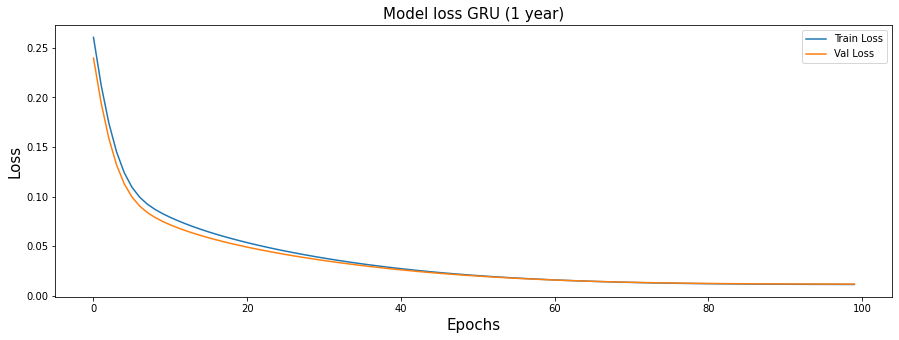

In [ ]:
# evaluate the GRU model (1 year)
plt.figure(figsize=(15,5))
plt.plot(model_gru_fit.history['loss'], label='Train Loss')
plt.plot(model_gru_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (1 year)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction
yhat_gru = model_gru.predict(test_X)
test_X_gru = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat_gru = concatenate((yhat_gru, test_X_gru[:, 1:]), axis=1)
inv_yhat_gru = scaler.inverse_transform(inv_yhat_gru)
inv_yhat_gru = inv_yhat_gru[:,0]

# invert scaling for actual
test_y_gru = test_y.reshape((len(test_y), 1))
inv_y_gru = concatenate((test_y_gru, test_X_gru[:, 1:]), axis=1)
inv_y_gru = scaler.inverse_transform(inv_y_gru)
inv_y_gru = inv_y_gru[:,0]

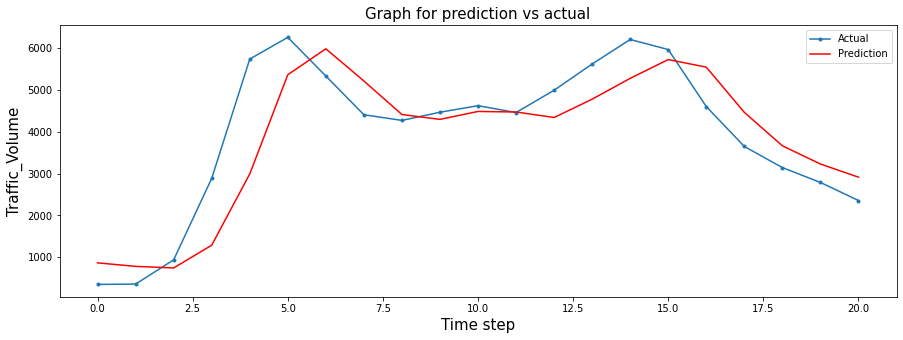

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15,5))
plt.plot(a,inv_y_gru[:21], marker='.', label="Actual")
plt.plot(a, inv_yhat_gru[:21], 'r', label="Prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_gru_1y = sqrt(mean_squared_error(inv_y_gru, inv_yhat_gru))
mse_gru_1y = mean_squared_error(inv_y_gru, inv_yhat_gru)
mae_gru_1y = mean_absolute_error(inv_y_gru, inv_yhat_gru)
pred_time_gru = math.acos(pred_time_gru[0])

eval_gru_1y = {'gru_1y' : [rmse_gru_1y, mse_gru_1y, mae_gru_1y, pred_time_gru]}

eval_gru_1y_df = pd.DataFrame(eval_gru_1y, columns = ['gru_1y'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_gru_1y_df

,gru_1y
Root Mean Square Error,794.282577
Mean Square Error,630884.812500
Mean Absolute Error,597.163025
Processing time in sec,1.342468


In this model, there was a similarity with that of the lstm model for 1 year. Here wa well there was a very high mse score as well as the forecast graph was not that accurate which we expected. This is because, we are trying to predict the data based on only previous 1 year which is a very less information.

#### GRU model using test, train, and validate

In [ ]:
# design network for train, test and validate
pred_time_gru_ttv=[]

start = time.clock()
model_gru_ttv = Sequential()
model_gru_ttv.add(GRU(10, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_gru_ttv.add(Dropout(0.5))
model_gru_ttv.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_gru_ttv.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_gru_ttv.append(end-start)

# fit network
model_gru_ttv_fit = model_gru_ttv.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

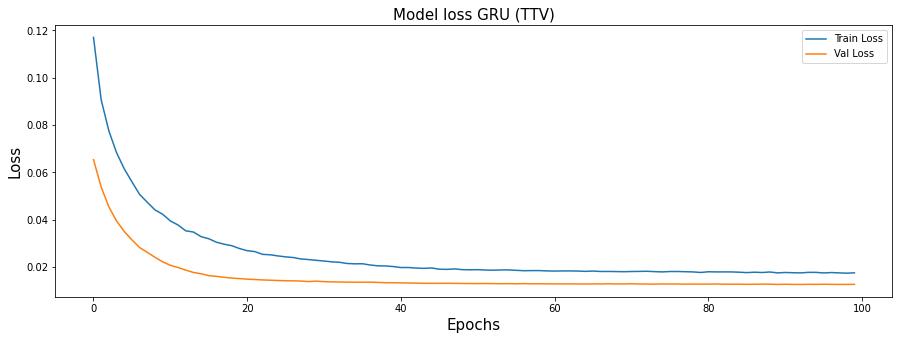

In [ ]:
# evaluate the GRU model for test train and validate
plt.figure(figsize=(15,5))
plt.plot(model_gru_ttv_fit.history['loss'], label='Train Loss')
plt.plot(model_gru_ttv_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (TTV)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_ttv_gru = model_gru_ttv.predict(X_test_ttv)
X_test_ttv_gru = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_ttv_gru = concatenate((ypred_ttv, X_test_rttv[:, 1:]), axis=1)
inv_ypred_ttv_gru = scaler.inverse_transform(inv_ypred_ttv_gru)
inv_ypred_ttv_gru = inv_ypred_ttv_gru[:,0]

# invert scaling for actual
y_test_ttv_gru = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_ttv_gru = concatenate((y_test_rttv, X_test_rttv[:, 1:]), axis=1)
inv_yact_ttv_gru = scaler.inverse_transform(inv_yact_ttv_gru)
inv_yact_ttv_gru = inv_yact_ttv_gru[:,0]

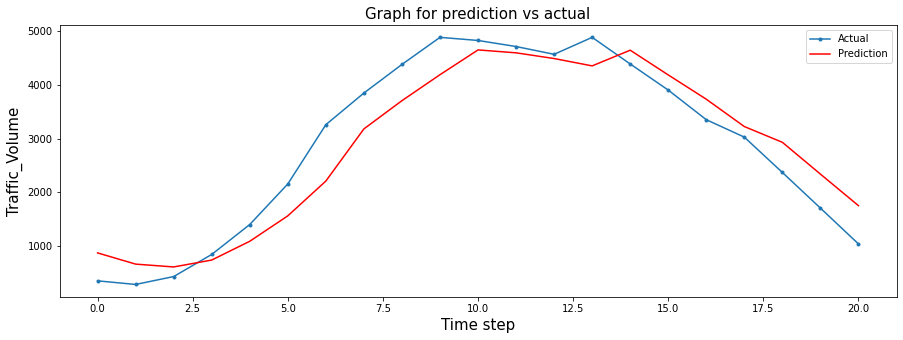

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15,5))
plt.plot(a,inv_yact_ttv_gru[:21], marker='.', label="Actual")
plt.plot(a, inv_ypred_ttv_gru[:21], 'r', label="Prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_gru_ttv = sqrt(mean_squared_error(inv_yact_ttv_gru, inv_ypred_ttv_gru))
mse_gru_ttv = mean_squared_error(inv_yact_ttv_gru, inv_ypred_ttv_gru)
mae_gru_ttv = mean_absolute_error(inv_yact_ttv_gru, inv_ypred_ttv_gru)
pred_time_gru_ttv = math.acos(pred_time_gru_ttv[0])

eval_lstm_ttv = {'gru_ttv' : [rmse_gru_ttv, mse_gru_ttv, mae_gru_ttv, pred_time_gru_ttv]}

eval_lstm_ttv_df = pd.DataFrame(eval_lstm_ttv, columns = ['gru_ttv'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_lstm_ttv_df

,gru_ttv
Root Mean Square Error,800.357733
Mean Square Error,640572.500000
Mean Absolute Error,604.351624
Processing time in sec,1.321653


#### GRU Model with varying hidden layers

In [ ]:
# design network for train, test and validate
pred_time_gru_hl=[]

start = time.clock()
model_gru_hl = Sequential()
model_gru_hl.add(GRU(10, return_sequences=True, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_gru_hl.add(Dropout(0.5))
model_gru_hl.add(GRU(10))
model_gru_hl.add(Dropout(0.5))
model_gru_hl.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_gru_hl.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_gru_hl.append(end-start)

# fit network
model_gru_hl_fit = model_gru_hl.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

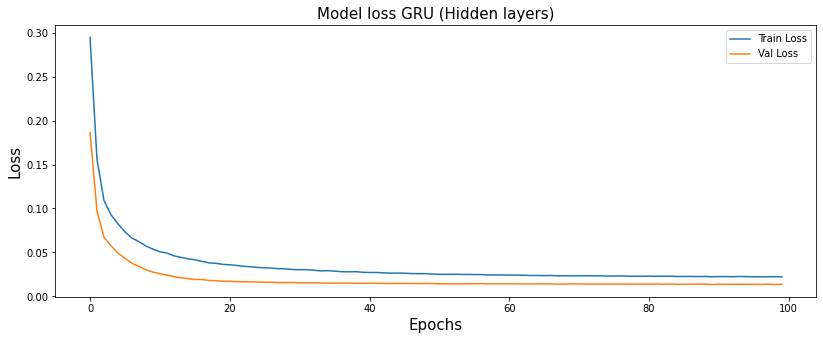

In [ ]:
# evaluate the keras model for varying hidden layers
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_gru_hl_fit.history['loss'], label='Train Loss')
plt.plot(model_gru_hl_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (Hidden layers)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_hl_gru = model_gru_hl.predict(X_test_ttv)
X_test_hl_gru = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_hl_gru = concatenate((ypred_hl_gru, X_test_hl_gru[:, 1:]), axis=1)
inv_ypred_hl_gru = scaler.inverse_transform(inv_ypred_hl_gru)
inv_ypred_hl_gru = inv_ypred_hl_gru[:,0]

# invert scaling for actual
y_test_hl_gru = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_hl_gru = concatenate((y_test_hl_gru, X_test_hl_gru[:, 1:]), axis=1)
inv_yact_hl_gru = scaler.inverse_transform(inv_yact_hl_gru)
inv_yact_hl_gru = inv_yact_hl_gru[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yact_hl_gru, inv_ypred_hl_gru))
print('Test RMSE for LSTM: %.3f' % rmse)

Test RMSE for LSTM: 840.723


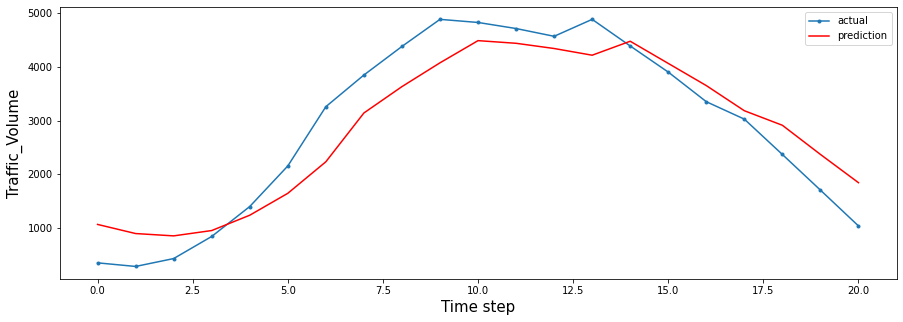

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_hl_gru[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_hl_gru[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_gru_hl = sqrt(mean_squared_error(inv_yact_hl_gru, inv_ypred_hl_gru))
mse_gru_hl = mean_squared_error(inv_yact_hl_gru, inv_ypred_hl_gru)
mae_gru_hl = mean_absolute_error(inv_yact_hl_gru, inv_ypred_hl_gru)
pred_time_gru_hl = math.acos(pred_time_gru_hl[0])

eval_gru_hl = {'gru_hl' : [rmse_gru_hl, mse_gru_hl, mae_gru_hl, pred_time_gru_hl]}

eval_gru_hl_df = pd.DataFrame(eval_gru_hl, columns = ['gru_hl'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_gru_hl_df

,gru_hl
Root Mean Square Error,840.723052
Mean Square Error,706815.250000
Mean Absolute Error,659.108826
Processing time in sec,1.088855


#### GRU model using lag timesteps

In [ ]:
# design network for train, test and validate
pred_time_gru_lag=[]

start = time.clock()
model_lag_gru = Sequential()
model_lag_gru.add(GRU(10, input_shape=(X_train_lag.shape[1], X_train_lag.shape[2])))
model_lag_gru.add(Dropout(0.5))
model_lag_gru.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_gru_lag.append(end-start)

# fit network
model_lag_gru_fit = model_lag_gru.fit(X_train_lag, y_train_lag, epochs=100, batch_size=1000, validation_data=(X_val_lag, y_val_lag), verbose=0, shuffle=False)

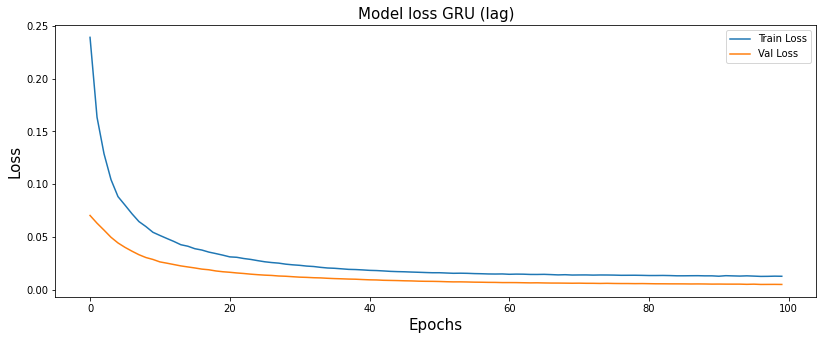

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_gru_fit.history['loss'], label='Train Loss')
plt.plot(model_lag_gru_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag_gru = model_lag_gru.predict(X_test_lag)
X_test_lag_gru = X_test_lag.reshape((X_test_lag.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag_gru = concatenate((ypred_lag_gru, X_test_lag_gru[:, -8:]), axis=1)
inv_ypred_lag_gru = scaler.inverse_transform(inv_ypred_lag_gru)
inv_ypred_lag_gru = inv_ypred_lag_gru[:,0]

# invert scaling for actual
y_test_lag_gru = y_test_lag.reshape((len(y_test_lag), 1))
inv_yact_lag_gru = concatenate((y_test_lag_gru, X_test_lag_gru[:, -8:]), axis=1)
inv_yact_lag_gru = scaler.inverse_transform(inv_yact_lag_gru)
inv_yact_lag_gru = inv_yact_lag_gru[:,0]

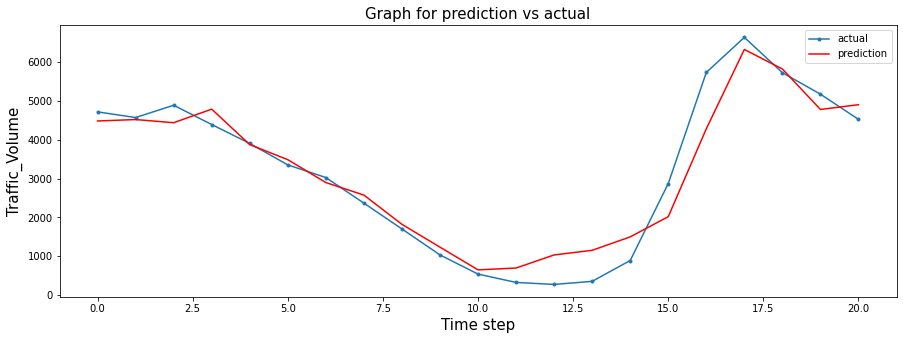

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_lag_gru[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_lag_gru[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_gru_lag = sqrt(mean_squared_error(inv_yact_lag_gru, inv_ypred_lag_gru))
mse_gru_lag = mean_squared_error(inv_yact_lag_gru, inv_ypred_lag_gru)
mae_gru_lag = mean_absolute_error(inv_yact_lag_gru, inv_ypred_lag_gru)
pred_time_gru_lag = math.acos(pred_time_gru_lag[0])

eval_gru_lag = {'lstm_lag' : [rmse_gru_lag, mse_gru_lag, mae_gru_lag, pred_time_gru_lag]}

eval_gru_lag_df = pd.DataFrame(eval_gru_lag, columns = ['lstm_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_gru_lag_df

,lstm_lag
Root Mean Square Error,472.818923
Mean Square Error,223557.734375
Mean Absolute Error,354.605499
Processing time in sec,1.309980


#### Conclusion for GRU model

In [ ]:
GRU_eval = {'gru_1y' : [rmse_gru_1y, mse_gru_1y, mae_gru_1y, pred_time_gru], 
             'gru_ttv' : [rmse_gru_ttv, mse_gru_ttv, mae_gru_ttv, pred_time_gru_ttv],
             'gru_hl' : [rmse_gru_hl, mse_gru_hl, mae_gru_hl, pred_time_gru_hl],
             'gru_lag' : [rmse_gru_lag, mse_gru_lag, mae_gru_lag, pred_time_gru_lag]       
            }

GRU_eval_df = pd.DataFrame(GRU_eval, columns = ['gru_1y','gru_ttv','gru_hl','gru_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
GRU_eval_df


,gru_1y,gru_ttv,gru_hl,gru_lag
Root Mean Square Error,794.282577,800.357733,840.723052,472.818923
Mean Square Error,630884.812500,640572.500000,706815.250000,223557.734375
Mean Absolute Error,597.163025,604.351624,659.108826,354.605499
Processing time in sec,1.342468,1.321653,1.088855,1.309980


Looking at the above data and predicted vs actual graph for eaach and every gru model, I can confidently say that among all of the above GRU models, model using lag = 12 is by far more accurate in forcasting.

## **RNN Model**

For the sake of fair comparison, we have used same parameters as hvae done for the lstm model. Although we did experimented with the parameters, but we still decided to the same parameters to highlight the difference in performance.

#### RNN model where data is predicted using the past 1 year

In [ ]:
# design network
pred_time_rnn=[]

start = time.clock()
model_rnn = Sequential()
model_rnn.add(SimpleRNN(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_rnn.append(end-start)

# fit network
model_rnn_fit = model_rnn.fit(train_X, train_y, epochs=100, batch_size=1000, validation_data=(test_X, test_y), verbose=0, shuffle=False)

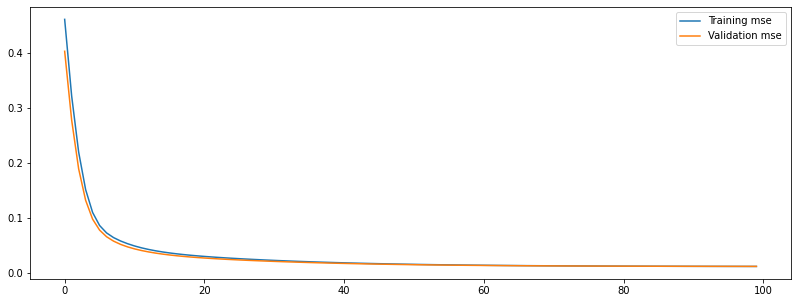

In [ ]:
# evaluate the keras model
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_rnn_fit.history['mean_squared_error'])
plt.plot(model_rnn_fit.history['val_mean_squared_error'])
plt.legend(['Training mse', 'Validation mse'])
plt.show()

In [ ]:
# make a prediction
yhat_rnn = model_rnn.predict(test_X)
test_X_rnn = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat_rnn = concatenate((yhat_rnn, test_X_rnn[:, 1:]), axis=1)
inv_yhat_rnn = scaler.inverse_transform(inv_yhat_rnn)
inv_yhat_rnn = inv_yhat_rnn[:,0]

# invert scaling for actual
test_y_rnn = test_y.reshape((len(test_y), 1))
inv_y_rnn = concatenate((test_y_rnn, test_X_rnn[:, 1:]), axis=1)
inv_y_rnn = scaler.inverse_transform(inv_y_rnn)
inv_y_rnn = inv_y_rnn[:,0]

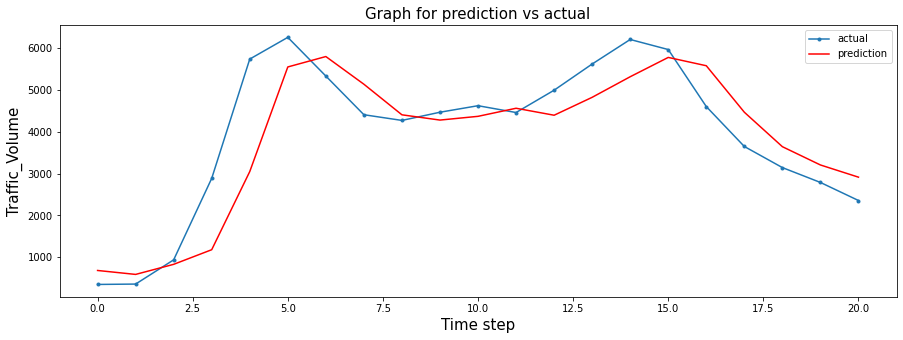

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_y_rnn[:21], marker='.', label="actual")
plt.plot(a, inv_yhat_rnn[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_rnn_1y = sqrt(mean_squared_error(inv_y_rnn, inv_yhat_rnn))
mse_rnn_1y = mean_squared_error(inv_y_rnn, inv_yhat_rnn)
mae_rnn_1y = mean_absolute_error(inv_y_rnn, inv_yhat_rnn)
pred_time_rnn = math.acos(pred_time_rnn[0])

eval_rnn_1y = {'rnn_1y' : [rmse_rnn_1y, mse_rnn_1y, mae_rnn_1y, pred_time_rnn]}

eval_rnn_1y_df = pd.DataFrame(eval_rnn_1y, columns = ['rnn_1y'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_rnn_1y_df

,rnn_1y
Root Mean Square Error,806.128208
Mean Square Error,649842.687500
Mean Absolute Error,613.626526
Processing time in sec,1.487920


#### RNN model using test, train, and validate 

In [ ]:
# design network for train, test and validate
pred_time_rnn_ttv=[]

start = time.clock()
model_rnn_ttv = Sequential()
model_rnn_ttv.add(SimpleRNN(10, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_rnn_ttv.add(Dropout(0.5))
model_rnn_ttv.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_rnn_ttv.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_rnn_ttv.append(end-start)

# fit network
model_rnn_ttv_fit = model_rnn_ttv.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

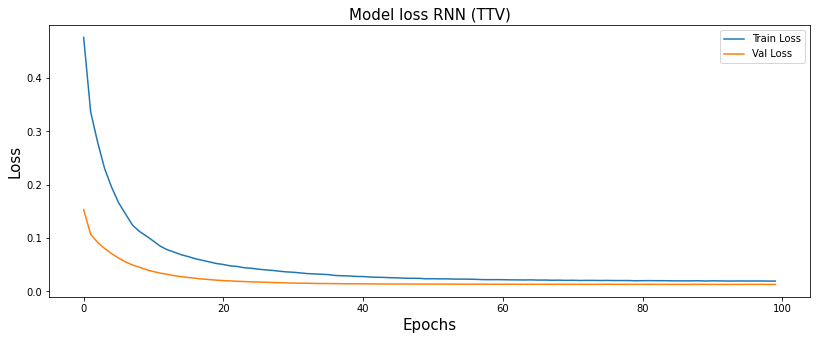

In [ ]:
# evaluate the keras model for TTV
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_rnn_ttv_fit.history['loss'], label='Train Loss')
plt.plot(model_rnn_ttv_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss RNN (TTV)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_ttv_rnn = model_rnn_ttv.predict(X_test_ttv)
X_test_ttv_rnn = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_ttv_rnn = concatenate((ypred_ttv, X_test_ttv_rnn[:, 1:]), axis=1)
inv_ypred_ttv_rnn = scaler.inverse_transform(inv_ypred_ttv_rnn)
inv_ypred_ttv_rnn = inv_ypred_ttv_rnn[:,0]

# invert scaling for actual
y_test_ttv_rnn = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_ttv_rnn = concatenate((y_test_ttv_rnn, X_test_ttv_rnn[:, 1:]), axis=1)
inv_yact_ttv_rnn = scaler.inverse_transform(inv_yact_ttv_rnn)
inv_yact_ttv_rnn = inv_yact_ttv_rnn[:,0]

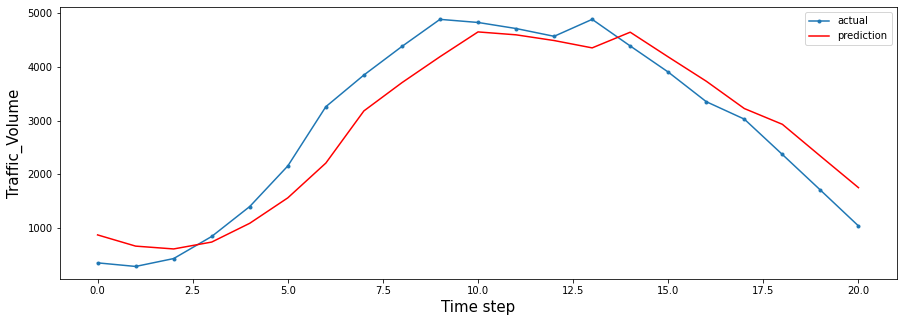

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15,5))
plt.plot(a,inv_yact_ttv_rnn[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_ttv_rnn[:21], 'r', label="prediction")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_rnn_ttv = sqrt(mean_squared_error(inv_yact_ttv_rnn, inv_ypred_ttv_rnn))
mse_rnn_ttv = mean_squared_error(inv_yact_ttv_rnn, inv_ypred_ttv_rnn)
mae_rnn_ttv = mean_absolute_error(inv_yact_ttv_rnn, inv_ypred_ttv_rnn)
pred_time_rnn_ttv = math.acos(pred_time_rnn_ttv[0])

eval_rnn_ttv = {'rnn_ttv' : [rmse_rnn_ttv, mse_rnn_ttv, mae_rnn_ttv, pred_time_rnn_ttv]}

eval_rnn_ttv_df = pd.DataFrame(eval_rnn_ttv, columns = ['rnn_ttv'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_rnn_ttv_df

,rnn_ttv
Root Mean Square Error,800.357733
Mean Square Error,640572.500000
Mean Absolute Error,604.351624
Processing time in sec,1.485189


#### RNN Model with varying hidden layers

In [ ]:
# design network for train, test and validate
pred_time_rnn_hl=[]

start = time.clock()
model_rnn_hl = Sequential()
model_rnn_hl.add(SimpleRNN(10, return_sequences=True, input_shape=(X_train_ttv.shape[1], X_train_ttv.shape[2])))
model_rnn_hl.add(Dropout(0.5))
model_rnn_hl.add(SimpleRNN(10))
model_rnn_hl.add(Dropout(0.5))
model_rnn_hl.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_rnn_hl.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_rnn_hl.append(end-start)

# fit network
model_rnn_hl_fit = model_rnn_hl.fit(X_train_ttv, y_train_ttv, epochs=100, batch_size=1000, validation_data=(X_val_ttv, y_val_ttv), verbose=0, shuffle=False)

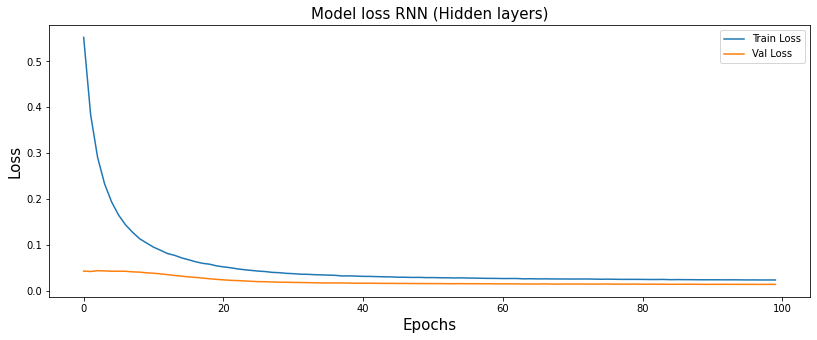

In [ ]:
# evaluate the keras model for varying hidden layers
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_rnn_hl_fit.history['loss'], label='Train Loss')
plt.plot(model_rnn_hl_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss RNN (Hidden layers)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_hl_rnn = model_rnn_hl.predict(X_test_ttv)
X_test_hl_rnn = X_test_ttv.reshape((X_test_ttv.shape[0], X_test_ttv.shape[2]))

# invert scaling for forecast
inv_ypred_hl_rnn = concatenate((ypred_hl_gru, X_test_hl_gru[:, 1:]), axis=1)
inv_ypred_hl_rnn = scaler.inverse_transform(inv_ypred_hl_rnn)
inv_ypred_hl_rnn = inv_ypred_hl_rnn[:,0]

# invert scaling for actual
y_test_hl_rnn = y_test_ttv.reshape((len(y_test_ttv), 1))
inv_yact_hl_rnn = concatenate((y_test_hl_rnn, X_test_hl_rnn[:, 1:]), axis=1)
inv_yact_hl_rnn = scaler.inverse_transform(inv_yact_hl_rnn)
inv_yact_hl_rnn = inv_yact_hl_rnn[:,0]

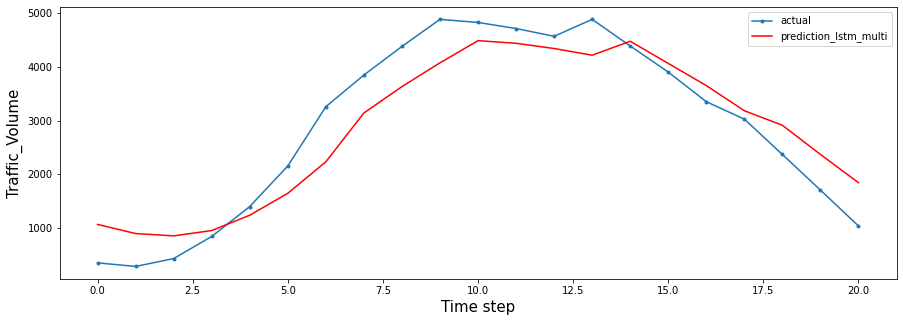

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_hl_rnn[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_hl_rnn[:21], 'r', label="prediction_lstm_multi")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_rnn_hl = sqrt(mean_squared_error(inv_yact_hl_rnn, inv_ypred_hl_rnn))
mse_rnn_hl = mean_squared_error(inv_yact_hl_rnn, inv_ypred_hl_rnn)
mae_rnn_hl = mean_absolute_error(inv_yact_hl_rnn, inv_ypred_hl_rnn)
pred_time_rnn_hl = math.acos(pred_time_rnn_hl[0])

eval_rnn_hl = {'rnn_hl' : [rmse_rnn_hl, mse_rnn_hl, mae_rnn_hl, pred_time_rnn_hl]}

eval_rnn_hl_df = pd.DataFrame(eval_rnn_hl, columns = ['rnn_hl'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_rnn_hl_df

,rnn_hl
Root Mean Square Error,840.723052
Mean Square Error,706815.250000
Mean Absolute Error,659.108826
Processing time in sec,1.434343


#### RNN model using lag timesteps

In [ ]:
# design network for train, test and validate
pred_time_rnn_lag=[]

start = time.clock()
model_lag_rnn = Sequential()
model_lag_rnn.add(SimpleRNN(10, input_shape=(X_train_lag.shape[1], X_train_lag.shape[2])))
model_lag_rnn.add(Dropout(0.5))
model_lag_rnn.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_rnn_lag.append(end-start)

# fit network
model_lag_rnn_fit = model_lag_rnn.fit(X_train_lag, y_train_lag, epochs=100, batch_size=1000, validation_data=(X_val_lag, y_val_lag), verbose=0, shuffle=False)

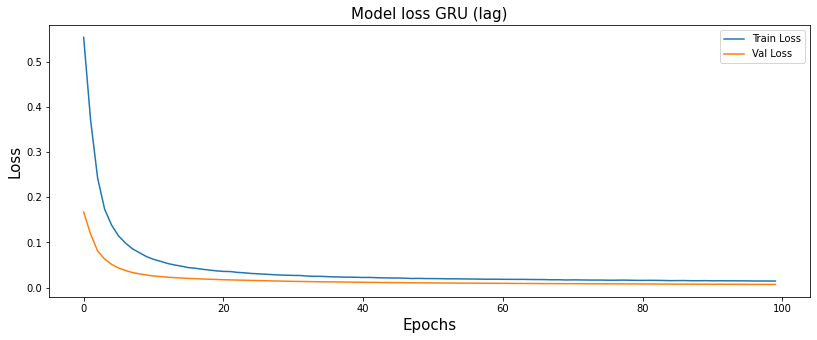

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_rnn_fit.history['loss'], label='Train Loss')
plt.plot(model_lag_rnn_fit.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag_rnn = model_lag_rnn.predict(X_test_lag)
X_test_lag_rnn = X_test_lag.reshape((X_test_lag.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag_rnn = concatenate((ypred_lag_rnn, X_test_lag_rnn[:, -8:]), axis=1)
inv_ypred_lag_rnn = scaler.inverse_transform(inv_ypred_lag_rnn)
inv_ypred_lag_rnn = inv_ypred_lag_rnn[:,0]

# invert scaling for actual
y_test_lag_rnn = y_test_lag.reshape((len(y_test_lag), 1))
inv_yact_lag_rnn = concatenate((y_test_lag_rnn, X_test_lag_rnn[:, -8:]), axis=1)
inv_yact_lag_rnn = scaler.inverse_transform(inv_yact_lag_rnn)
inv_yact_lag_rnn = inv_yact_lag_rnn[:,0]

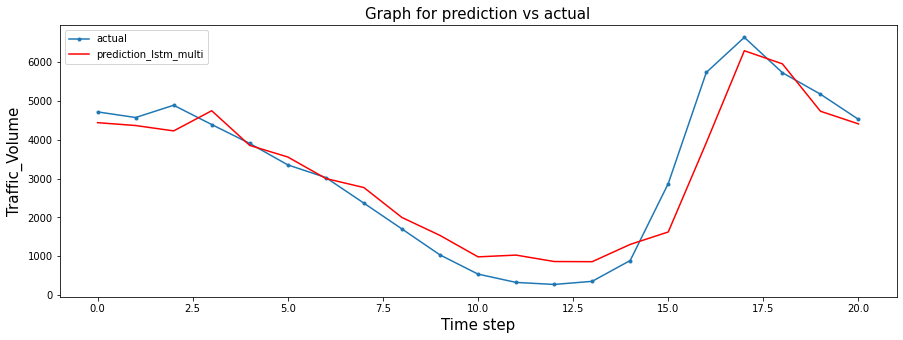

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a,inv_yact_lag_rnn[:21], marker='.', label="actual")
plt.plot(a, inv_ypred_lag_rnn[:21], 'r', label="prediction_lstm_multi")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_rnn_lag = sqrt(mean_squared_error(inv_yact_lag_rnn, inv_ypred_lag_rnn))
mse_rnn_lag = mean_squared_error(inv_yact_lag_rnn, inv_ypred_lag_rnn)
mae_rnn_lag = mean_absolute_error(inv_yact_lag_rnn, inv_ypred_lag_rnn)
pred_time_rnn_lag = math.acos(pred_time_rnn_lag[0])

eval_rnn_lag = {'rnn_lag' : [rmse_rnn_lag, mse_rnn_lag, mae_rnn_lag, pred_time_rnn_lag]}

eval_rnn_lag_df = pd.DataFrame(eval_rnn_lag, columns = ['rnn_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_rnn_lag_df

,rnn_lag
Root Mean Square Error,584.934238
Mean Square Error,342148.062500
Mean Absolute Error,449.677582
Processing time in sec,1.487445


#### Conlusion for RNN model

In [ ]:
RNN_eval = {'rnn_1y' : [rmse_rnn_1y, mse_rnn_1y, mae_rnn_1y, pred_time_rnn], 
             'rnn_ttv' : [rmse_rnn_ttv, mse_rnn_ttv, mae_rnn_ttv, pred_time_rnn_ttv],
             'rnn_hl' : [rmse_rnn_hl, mse_rnn_hl, mae_rnn_hl, pred_time_rnn_hl],
             'rnn_lag' : [rmse_rnn_lag, mse_rnn_lag, mae_rnn_lag, pred_time_rnn_lag]       
            }

RNN_eval_df = pd.DataFrame(RNN_eval, columns = ['rnn_1y','rnn_ttv','rnn_hl','rnn_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
RNN_eval_df


,rnn_1y,rnn_ttv,rnn_hl,rnn_lag
Root Mean Square Error,806.128208,800.357733,840.723052,584.934238
Mean Square Error,649842.687500,640572.500000,706815.250000,342148.062500
Mean Absolute Error,613.626526,604.351624,659.108826,449.677582
Processing time in sec,1.487920,1.485189,1.434343,1.487445


It was difficult to assess the best model among these since the graphs were a bit similar in forcasting. But there was a significant difference observed in the mse score among themodels. The best one among them was again the model with lag = 12. Although the processing time was a little higher than the other models, it was still within expectable range.

## **Conclusion**

I have picked the best models among each type of model that I ran and listed a comparison between them below


In [ ]:
eval = {'lstm_lag' : [rmse_lstm_lag, mse_lstm_lag, mae_lstm_lag, pred_time_lstm_lag],
        'gru_lag' : [rmse_gru_lag, mse_gru_lag, mae_gru_lag, pred_time_gru_lag],       
        'rnn_lag' : [rmse_rnn_lag, mse_rnn_lag, mae_rnn_lag, pred_time_rnn_lag]       
       }

eval_df = pd.DataFrame(eval, columns = ['lstm_lag','gru_lag','rnn_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_df


,lstm_lag,gru_lag,rnn_lag
Root Mean Square Error,476.987307,472.818923,584.934238
Mean Square Error,227516.890625,223557.734375,342148.062500
Mean Absolute Error,357.985229,354.605499,449.677582
Processing time in sec,1.280958,1.309980,1.487445


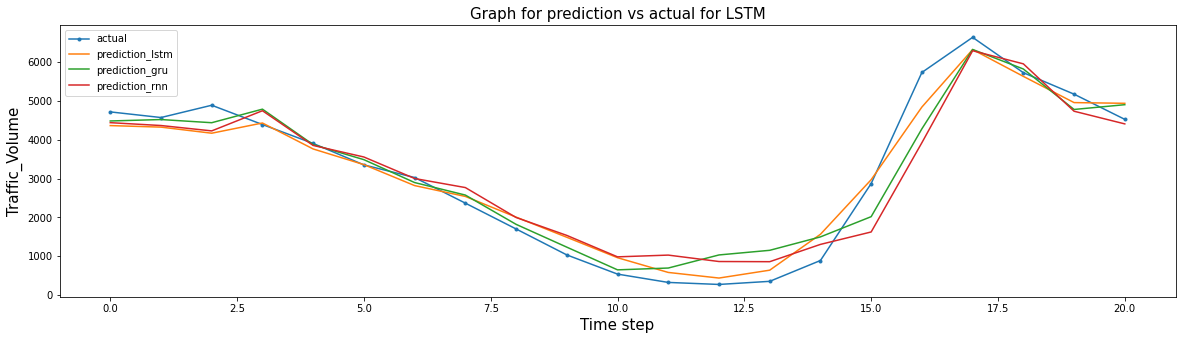

In [ ]:
# Graph for prediction vs actual
a=[x for x in range(21)]
b=[x for x in range(21)]
c=[x for x in range(21)]

plt.figure(figsize=(20,5))

plt.plot(a,inv_yact_lag[:21], marker='.', label="actual")
#plt.plot(b,inv_yact_lag_gru[:21], marker='.', label="actual")
#plt.plot(c,inv_yact_lag_rnn[:21], marker='.', label="actual")
# The above lines have same values thus used only one


plt.plot(a, inv_ypred_lag[:21], label="prediction_lstm")
plt.plot(b, inv_ypred_lag_gru[:21], label="prediction_gru")
plt.plot(c, inv_ypred_lag_rnn[:21], label="prediction_rnn")

plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual for LSTM', size=15)

plt.legend(fontsize=10)
plt.show();

In [ ]:
model_lag.summary()
model_lag_gru.summary()
model_lag_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 10)                630       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
__________________________________

If we just look at the numbers, it is safe to say that lstm_lag model is the best bet for forecasting. But if we try to figure out using the graph, it is very difficult to say since they are somewhat similar. Even the processing time is similar except rnn(which is higher).
But in my opinion, GRU is a bit more accurate with less MSE and MAE as compared to others although it takes more memory to run because of large number of parameters. Thus at the end, it basically comes down to the parameters that are suitable to you for comaprison.

I would go with GRU on this one

# **Experiment 2**

Now we will experiment the dataset by dropping some columns and record the result. For this experiment we will drop the Weekend, Day_Week and holiday columns. 

For this experiment, I will only use the best models from above, i.e. models using lags, record the results and compare them with previous results. 

In [ ]:
dataset2 = dataset.copy()

In [ ]:
dataset2 = dataset2.drop(columns=['Day_Week', 'Weekend', 'holiday'])
dataset2.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_desc
date_time_new,,,,,,
2013-01-01 00:00:00,1439.0,-9.66,0.0,0.0,58.0,1
2013-01-01 01:00:00,1502.0,-9.37,0.0,0.0,40.0,1
2013-01-01 02:00:00,933.0,-8.99,0.0,0.0,75.0,7
2013-01-01 03:00:00,576.0,-9.20,0.0,0.0,90.0,1
2013-01-01 04:00:00,372.0,-9.50,0.0,0.0,90.0,1


## **Data Preparation**

In [ ]:
# ensure all data is float
values2 = dataset2.values
values2 = values2.astype('float32')
# normalize features
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler2.fit_transform(values2)

In [ ]:
# specify the number of lag hours
n_hours = 12
n_features = 6

# split into train, test and validate sets
n_obs = n_hours * n_features
reframed_lag2 = series_to_supervised(scaled2, n_hours, 1)
values_lag2 = reframed_lag2.values
train_lag2, val_lag2, test_lag2 = values_lag2[:26089,:], values_lag2[26090:33552,:], values_lag2[33553:,:]

# split into input and outputs
X_train_lag2, y_train_lag2 = train_lag2[:, :n_obs], train_lag2[:, -n_features]
X_val_lag2, y_val_lag2 = val_lag2[:, :n_obs], val_lag2[:, -n_features]
X_test_lag2, y_test_lag2 = test_lag2[:, :n_obs], test_lag2[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
X_train_lag2 = X_train_lag2.reshape((X_train_lag2.shape[0], n_hours, n_features))
X_val_lag2 = X_val_lag2.reshape((X_val_lag2.shape[0], n_hours, n_features))
X_test_lag2 = X_test_lag2.reshape((X_test_lag2.shape[0], n_hours, n_features))
print(X_train_lag2.shape, X_val_lag2.shape, X_test_lag2.shape)

(26089, 12, 6) (7462, 12, 6) (3706, 12, 6)


## **LSTM Model**

#### LSTM model using lag timesteps

In [ ]:
# design network for train, test and validate

pred_time_lstm_lag2=[]

start = time.clock()
model_lag2 = Sequential()
model_lag2.add(LSTM(10, input_shape=(X_train_lag2.shape[1], X_train_lag2.shape[2])))
model_lag2.add(Dropout(0.5))
model_lag2.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_lstm_lag2.append(end-start)

# fit network
model_lag_fit2 = model_lag2.fit(X_train_lag2, y_train_lag2, epochs=100, batch_size=1000, validation_data=(X_val_lag2, y_val_lag2), verbose=0, shuffle=False)

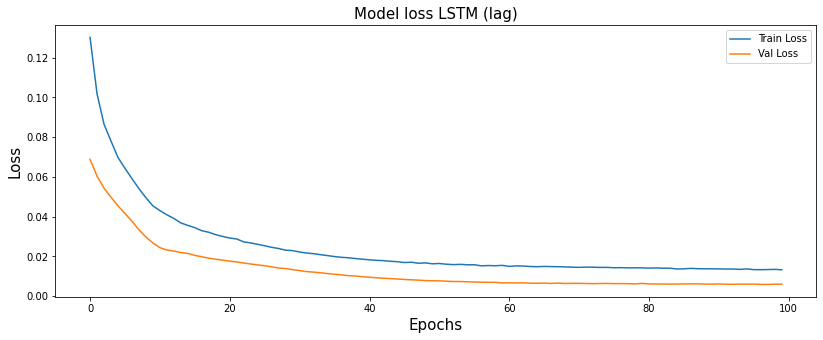

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_fit2.history['loss'], label='Train Loss')
plt.plot(model_lag_fit2.history['val_loss'], label='Val Loss')
plt.title('Model loss LSTM (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag2 = model_lag2.predict(X_test_lag2)
X_test_lag_lstm2 = X_test_lag2.reshape((X_test_lag2.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag2 = concatenate((ypred_lag2, X_test_lag_lstm2[:, -5:]), axis=1)
inv_ypred_lag2 = scaler2.inverse_transform(inv_ypred_lag2)
inv_ypred_lag2 = inv_ypred_lag2[:,0]

# invert scaling for actual
y_test_lag_lstm2 = y_test_lag2.reshape((len(y_test_lag2), 1))
inv_yact_lag2 = concatenate((y_test_lag_lstm2, X_test_lag_lstm2[:, -5:]), axis=1)
inv_yact_lag2 = scaler2.inverse_transform(inv_yact_lag2)
inv_yact_lag2 = inv_yact_lag2[:,0]

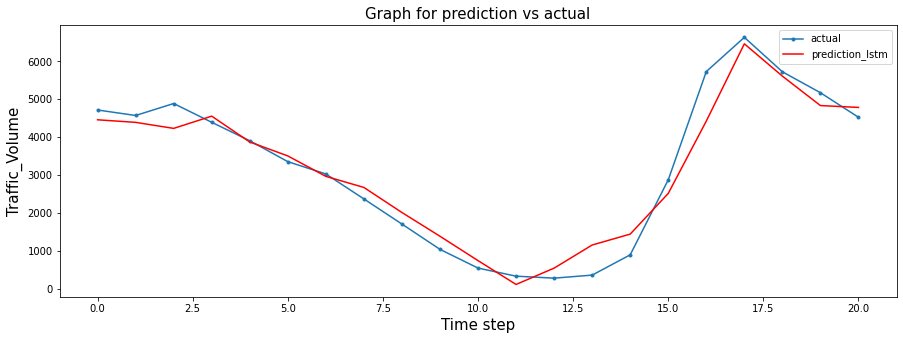

In [ ]:
# Graph for prediction vs actual
a2=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(a2,inv_yact_lag2[:21], marker='.', label="actual")
plt.plot(a2, inv_ypred_lag2[:21], 'r', label="prediction_lstm")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_lstm_lag2 = sqrt(mean_squared_error(inv_yact_lag2, inv_ypred_lag2))
mse_lstm_lag2 = mean_squared_error(inv_yact_lag2, inv_ypred_lag2)
mae_lstm_lag2 = mean_absolute_error(inv_yact_lag2, inv_ypred_lag2)
pred_time_lstm_lag2 = math.acos(pred_time_lstm_lag2[0])

eval_lstm_lag2 = {'lstm_lag' : [rmse_lstm_lag2, mse_lstm_lag2, mae_lstm_lag2, pred_time_lstm_lag2]}

eval_lstm_lag_df2 = pd.DataFrame(eval_lstm_lag2, columns = ['lstm_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_lstm_lag_df2

,lstm_lag
Root Mean Square Error,522.781951
Mean Square Error,273300.968750
Mean Absolute Error,398.906219
Processing time in sec,1.298506


## **GRU Model**

In [ ]:
# design network for train, test and validate
pred_time_gru_lag2=[]

start = time.clock()
model_lag_gru2 = Sequential()
model_lag_gru2.add(GRU(10, input_shape=(X_train_lag2.shape[1], X_train_lag2.shape[2])))
model_lag_gru2.add(Dropout(0.5))
model_lag_gru2.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag_gru2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_gru_lag2.append(end-start)

# fit network
model_lag_gru_fit2 = model_lag_gru2.fit(X_train_lag2, y_train_lag2, epochs=100, batch_size=1000, validation_data=(X_val_lag2, y_val_lag2), verbose=0, shuffle=False)

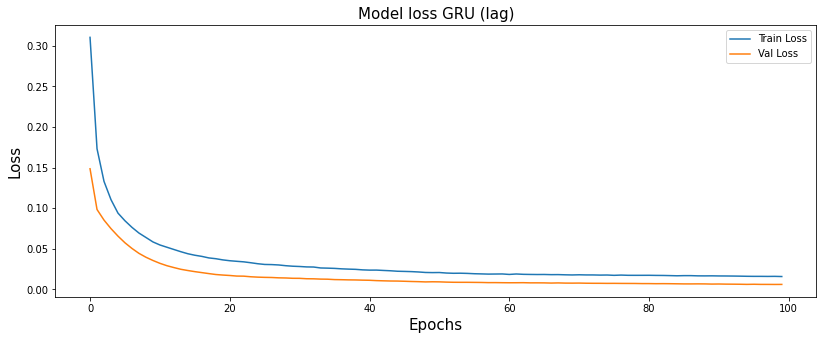

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_gru_fit2.history['loss'], label='Train Loss')
plt.plot(model_lag_gru_fit2.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag_gru2 = model_lag_gru2.predict(X_test_lag2)
X_test_lag_gru2 = X_test_lag2.reshape((X_test_lag2.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag_gru2 = concatenate((ypred_lag_gru2, X_test_lag_gru2[:, -5:]), axis=1)
inv_ypred_lag_gru2 = scaler2.inverse_transform(inv_ypred_lag_gru2)
inv_ypred_lag_gru2 = inv_ypred_lag_gru2[:,0]

# invert scaling for actual
y_test_lag_gru2 = y_test_lag2.reshape((len(y_test_lag2), 1))
inv_yact_lag_gru2 = concatenate((y_test_lag_gru2, X_test_lag_gru2[:, -5:]), axis=1)
inv_yact_lag_gru2 = scaler2.inverse_transform(inv_yact_lag_gru2)
inv_yact_lag_gru2 = inv_yact_lag_gru2[:,0]

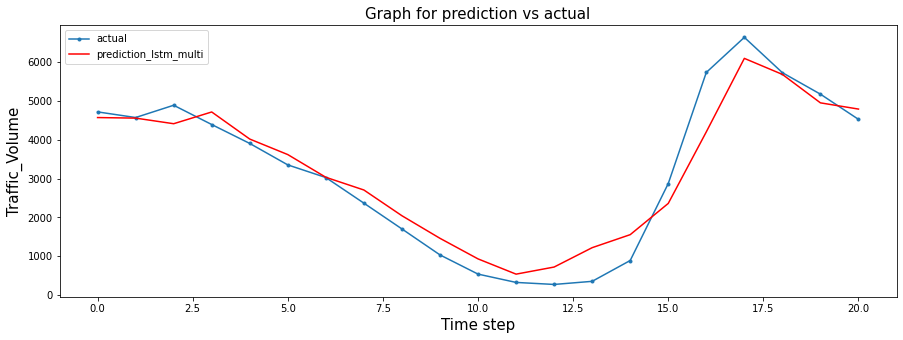

In [ ]:
# Graph for prediction vs actual
b2=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(b2,inv_yact_lag_gru2[:21], marker='.', label="actual")
plt.plot(b2, inv_ypred_lag_gru2[:21], 'r', label="prediction_lstm_multi")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_gru_lag2 = sqrt(mean_squared_error(inv_yact_lag_gru2, inv_ypred_lag_gru2))
mse_gru_lag2 = mean_squared_error(inv_yact_lag_gru2, inv_ypred_lag_gru2)
mae_gru_lag2 = mean_absolute_error(inv_yact_lag_gru2, inv_ypred_lag_gru2)
pred_time_gru_lag2 = math.acos(pred_time_gru_lag2[0])

eval_gru_lag2 = {'lstm_lag' : [rmse_gru_lag2, mse_gru_lag2, mae_gru_lag2, pred_time_gru_lag2]}

eval_gru_lag_df2 = pd.DataFrame(eval_gru_lag2, columns = ['lstm_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_gru_lag_df2

,lstm_lag
Root Mean Square Error,535.924785
Mean Square Error,287215.375000
Mean Absolute Error,424.057068
Processing time in sec,1.332539


## **RNN model**

In [ ]:
# design network for train, test and validate
pred_time_rnn_lag2=[]

start = time.clock()
model_lag_rnn2 = Sequential()
model_lag_rnn2.add(SimpleRNN(10, input_shape=(X_train_lag2.shape[1], X_train_lag2.shape[2])))
model_lag_rnn2.add(Dropout(0.5))
model_lag_rnn2.add(Dense(1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
model_lag_rnn2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
end = time.clock()
pred_time_rnn_lag2.append(end-start)

# fit network
model_lag_rnn_fit2 = model_lag_rnn2.fit(X_train_lag2, y_train_lag2, epochs=100, batch_size=1000, validation_data=(X_val_lag2, y_val_lag2), verbose=0, shuffle=False)

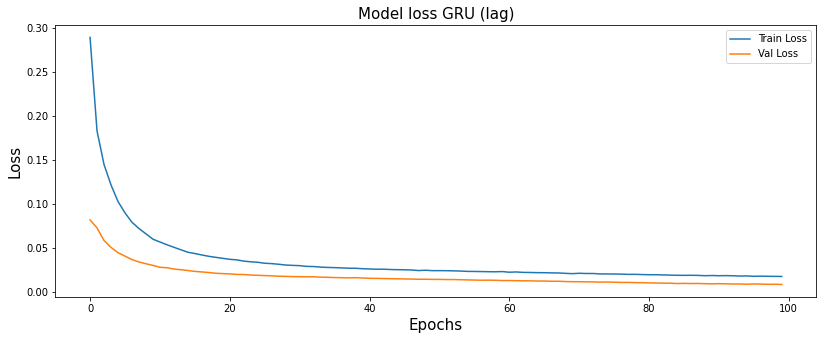

In [ ]:
# evaluate the keras model for 1 year
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(model_lag_rnn_fit2.history['loss'], label='Train Loss')
plt.plot(model_lag_rnn_fit2.history['val_loss'], label='Val Loss')
plt.title('Model loss GRU (lag)', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)
plt.legend(loc='upper right')
plt.show();

In [ ]:
# make a prediction 
ypred_lag_rnn2 = model_lag_rnn2.predict(X_test_lag2)
X_test_lag_rnn2 = X_test_lag2.reshape((X_test_lag2.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_ypred_lag_rnn2 = concatenate((ypred_lag_rnn2, X_test_lag_rnn2[:, -5:]), axis=1)
inv_ypred_lag_rnn2 = scaler2.inverse_transform(inv_ypred_lag_rnn2)
inv_ypred_lag_rnn2 = inv_ypred_lag_rnn2[:,0]

# invert scaling for actual
y_test_lag_rnn2 = y_test_lag2.reshape((len(y_test_lag2), 1))
inv_yact_lag_rnn2 = concatenate((y_test_lag_rnn2, X_test_lag_rnn2[:, -5:]), axis=1)
inv_yact_lag_rnn2 = scaler2.inverse_transform(inv_yact_lag_rnn2)
inv_yact_lag_rnn2 = inv_yact_lag_rnn2[:,0]

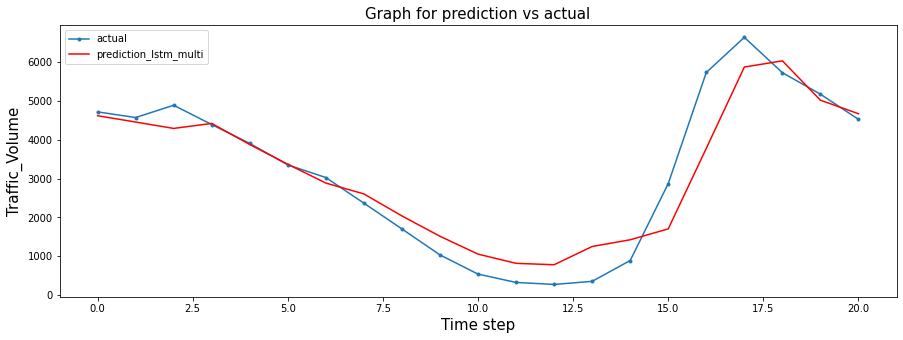

In [ ]:
# Graph for prediction vs actual
c2=[x for x in range(21)]
plt.figure(figsize=(15, 5))
plt.plot(c2,inv_yact_lag_rnn2[:21], marker='.', label="actual")
plt.plot(c2, inv_ypred_lag_rnn2[:21], 'r', label="prediction_lstm_multi")
plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual', size=15)
plt.legend(fontsize=10)
plt.show();

In [ ]:
# Model Evaluation
rmse_rnn_lag2 = sqrt(mean_squared_error(inv_yact_lag_rnn2, inv_ypred_lag_rnn2))
mse_rnn_lag2 = mean_squared_error(inv_yact_lag_rnn2, inv_ypred_lag_rnn2)
mae_rnn_lag2 = mean_absolute_error(inv_yact_lag_rnn2, inv_ypred_lag_rnn2)
pred_time_rnn_lag2 = math.acos(pred_time_rnn_lag2[0])

eval_rnn_lag2 = {'rnn_lag' : [rmse_rnn_lag2, mse_rnn_lag2, mae_rnn_lag2, pred_time_rnn_lag2]}

eval_rnn_lag_df2 = pd.DataFrame(eval_rnn_lag2, columns = ['rnn_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_rnn_lag_df2

,rnn_lag
Root Mean Square Error,653.744646
Mean Square Error,427382.062500
Mean Absolute Error,518.751282
Processing time in sec,1.487494


## **Conclusion**

In [ ]:
eval2 = {'lstm_lag' : [rmse_lstm_lag2, mse_lstm_lag2, mae_lstm_lag2, pred_time_lstm_lag2],
        'gru_lag' : [rmse_gru_lag2, mse_gru_lag2, mae_gru_lag2, pred_time_gru_lag2],       
        'rnn_lag' : [rmse_rnn_lag2, mse_rnn_lag2, mae_rnn_lag2, pred_time_rnn_lag2]       
       }

eval_df2 = pd.DataFrame(eval2, columns = ['lstm_lag','gru_lag','rnn_lag'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
eval_df2


,lstm_lag,gru_lag,rnn_lag
Root Mean Square Error,522.781951,535.924785,653.744646
Mean Square Error,273300.968750,287215.375000,427382.062500
Mean Absolute Error,398.906219,424.057068,518.751282
Processing time in sec,1.298506,1.332539,1.487494


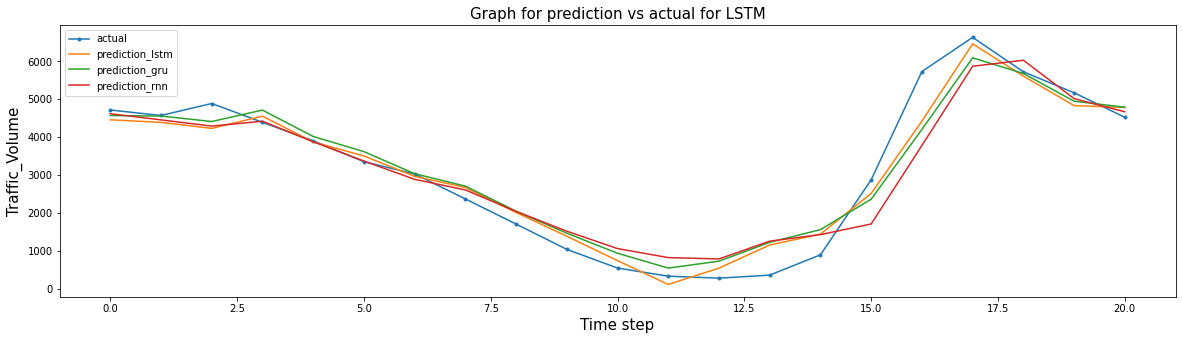

In [ ]:
# Graph for prediction vs actual
a2=[x for x in range(21)]
b2=[x for x in range(21)]
c2=[x for x in range(21)]

plt.figure(figsize=(20,5))

plt.plot(a2,inv_yact_lag2[:21], marker='.', label="actual")
#plt.plot(b,inv_yact_lag_gru[:21], marker='.', label="actual")
#plt.plot(c,inv_yact_lag_rnn[:21], marker='.', label="actual")
# The above lines have same values thus used only one


plt.plot(a2, inv_ypred_lag2[:21], label="prediction_lstm")
plt.plot(b2, inv_ypred_lag_gru2[:21], label="prediction_gru")
plt.plot(c2, inv_ypred_lag_rnn2[:21], label="prediction_rnn")

plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual for LSTM', size=15)

plt.legend(fontsize=10)
plt.show();

In [ ]:
model_lag2.summary()
model_lag_gru2.summary()
model_lag_rnn2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                680       
_________________________________________________________________
dropout_13 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 10)                540       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
________________________________

If we just look at the numbers, it is safe to say that gru_lag model is the best bet for forecasting. But if we try to figure out using the graph, it is very difficult to say since they are somewhat similar. Even the processing time is similar with a negligible difference between them . But in my opinion, GRU is a bit more accurate with less MSE and MAE as compared to others although it takes more memory to run because of large number of parameters.

# **Conclusion between 2 experiments**

In [ ]:
final_eval = {'gru_lag EXP1' : [rmse_gru_lag, mse_gru_lag, mae_gru_lag, pred_time_gru_lag],
              'gru_lag EXP2' : [rmse_gru_lag2, mse_gru_lag2, mae_gru_lag2, pred_time_gru_lag2]          
             }

final_eval_df2 = pd.DataFrame(final_eval, columns = ['gru_lag EXP1','gru_lag EXP2'], index=['Root Mean Square Error', 'Mean Square Error','Mean Absolute Error','Processing time in sec'])
final_eval_df2


,gru_lag EXP1,gru_lag EXP2
Root Mean Square Error,472.818923,535.924785
Mean Square Error,223557.734375,287215.375000
Mean Absolute Error,354.605499,424.057068
Processing time in sec,1.309980,1.332539


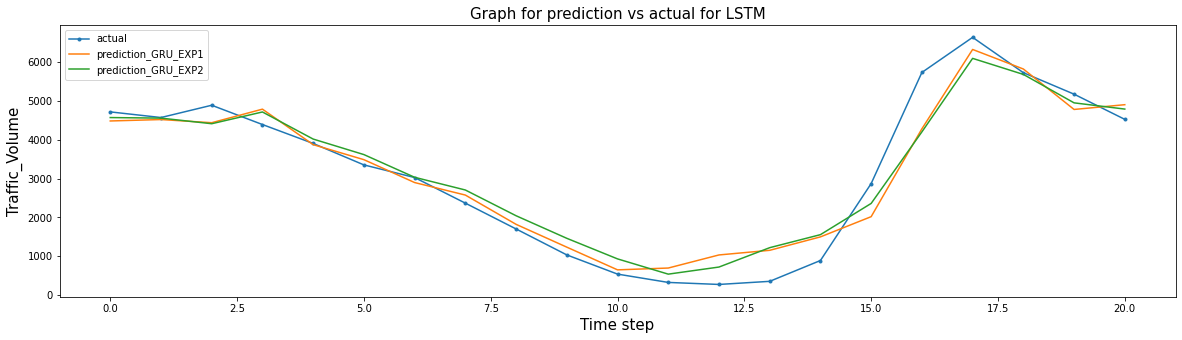

In [ ]:
# Graph for prediction vs actual
b=[x for x in range(21)]
a2=[x for x in range(21)]

plt.figure(figsize=(20,5))

plt.plot(a2,inv_yact_lag2[:21], marker='.', label="actual")

plt.plot(a, inv_ypred_lag_gru[:21], label="prediction_GRU_EXP1")
plt.plot(a2, inv_ypred_lag_gru2[:21], label="prediction_GRU_EXP2")

plt.ylabel('Traffic_Volume', size=15)
plt.xlabel('Time step', size=15)
plt.title('Graph for prediction vs actual for LSTM', size=15)

plt.legend(fontsize=10)
plt.show();

In [ ]:
model_lag_gru.summary()
model_lag_gru2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 10)                630       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 10)                540       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
_________________________________

Looking at the graph, one can say that GRU model from EXP 1 has better results compared to the GRU model in experiment 2. It even has low MSE and MAE as comapred to other.

This means that removing the columns from the dataset did not help in the final run.


Thus, I would say that GRU model from experiment 1 had the best overall result and is most suitable for forcasting the traffic volume accurately as compred to others, 

# **References**

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

https://www.kaggle.com/willkoehrsen/neural-network-embedding-recommendation-system

https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651

https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/